## plot_NWTcommunities_CLM
#### Plots simulated soil temperature and  water state for multiple sites

* All sims use newPHS parameterization and low SLA (0.01 m2/gC)
* FF and DM also have sandier soils & higher leaf CN (32 vs 24).

#### NWT observations have been pre-processed by `prepare_obs_for_comparison.R`
- Synthesizes data and calculates averages by veg type
- Created by Will Wieder, Oct 2020

In [2]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Point to simulations

In [5]:
years = range(2011,2019)
nmon  = 12
rollHour = -12  

longSite  =  ['fell_field','dry_meadow','moist_meadow','wet_meadow','snowbed']
veg  = ['ff','dm','mm','wm','sb']
site = [veg[v]+'_newPHS_lowSLA' for v in range(len(veg)) ]
site[0] = site[0]+'_SAND_cn32'
site[1] = site[1]+'_SAND_cn32'
print(site)
case  = ['clm50bgc_NWT_'+site[v] for v in range(len(veg)) ]

OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'
OBSdir = [OBSdir +longSite[v]+'/' for v in range(len(veg)) ]
OUTdir = OBSdir

# Points to simulation files
CLMdir = ['/glade/scratch/wwieder/archive/'+case[v]+'/lnd/hist/' 
      for  v in range(len(veg)) ]
CLMfile = [[]] *len(veg)
CLMmon  = [[]] *len(veg)
for v in range(len(veg)):
    # each h1 file
    CLMfile[v] = [CLMdir[v] + case[v] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' 
                  for i in range(len(years)) ]  
    # single month of data for soil C pools 
    CLMmon[v] = [CLMdir[v] + case[v] +'.clm2.h0.'+str(years[0])+'-01.nc'] 

CLMfile[0][0]

['ff_newPHS_lowSLA_SAND_cn32', 'dm_newPHS_lowSLA_SAND_cn32', 'mm_newPHS_lowSLA', 'wm_newPHS_lowSLA', 'sb_newPHS_lowSLA']


'/glade/scratch/wwieder/archive/clm50bgc_NWT_ff_newPHS_lowSLA_SAND_cn32/lnd/hist/clm50bgc_NWT_ff_newPHS_lowSLA_SAND_cn32.clm2.h1.2011-01-01-00000.nc'

### Read in dataset 
- combine along new dimension `vegdim`
- get rid of extra `lndgrid` dimension
- remove CLM time shift

In [6]:
dsCLM = [xr.open_mfdataset(CLMfile[v], decode_times=True, combine='by_coords') for v in range(len(veg)) ]
vegdim = xr.DataArray(longSite, dims='veg', name='veg') 
dsCLM = xr.concat(dsCLM, dim=vegdim)
dsCLM = dsCLM.isel(lndgrid=0)
dsCLM = dsCLM.shift(time=-1)
print('---- read  in data  ----')

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/scratch/wwieder/archive/clm50bgc_NWT_dm_newPHS_lowSLA_SAND_cn32/lnd/hist/clm50bgc_NWT_dm_newPHS_lowSLA_SAND_cn32.clm2.h1.2011-01-01-00000.nc'

In [4]:
# create new variables to subset data
dsCLM['year']  = dsCLM['time.year']
dsCLM['month']  = dsCLM['time.month']
dsCLM['season'] = dsCLM['time.season']

#Can't groupby hour & minutes, so combine them here
dsCLM['HourMin'] = np.round(dsCLM['time.hour'] + dsCLM['time.minute']/60,1)
dsCLM['MonDay'] = np.round(dsCLM['time.month'] + dsCLM['time.day']/100,2)

#  total preciptiation
dsCLM['ppt'] = dsCLM.RAIN + dsCLM.SNOW
dsCLM['ppt'].attrs['units'] = dsCLM.RAIN.attrs['units']
dsCLM['ppt'].attrs['long_name'] = 'RAIN + SNOW'

## Read in observatons 
#### These results have been pre-processed by `prepare_obs_for_comparison.R`
- Synthesizes data and calculates averages by veg type

In [5]:
nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsNPP.data = pd.to_datetime(dsNPP.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

In [6]:
#print(dsSOI)

In [7]:
# Aggregate data by date & vegetation community 
# This is already done for snowdepth
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

In [8]:
#dsSOIdaily
#dsSOIdaily.groupby(['veg_com'])['soiltemp_upper_avg'].plot(x='date',by='veg_com',legend=True);
#dsTVandaily['soiltemp_upper_avg'].plot();
#dsNETdaily['soiltemp_upper_avg']['mean']

### Convert Saddle network data to xarray

In [9]:
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()

# reindex by veg community for plotting consistency
Veg = ["FF", "DM", "MM",'WM','SB']
fullVeg = ["fell_field", "dry_meadow", "moist_meadow",'wet_meadow','snowbed']
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

dsCLM = dsCLM.reindex({'veg': fullVeg})

### Quick look at data

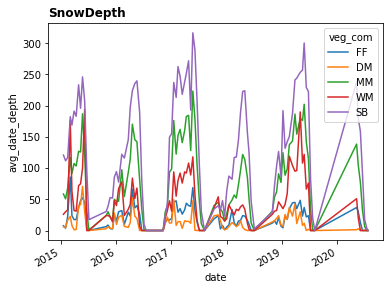

In [10]:
# Snow depth
dsSNO.where(dsSNO['date.year']>2014).avg_date_depth.plot(hue='veg_com');
plt.title('SnowDepth', loc='left', fontsize='large', fontweight='bold');

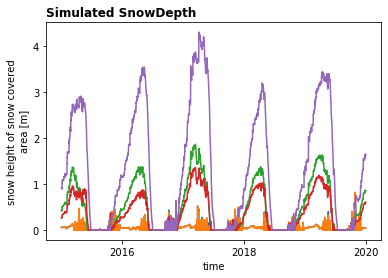

In [14]:
## Same for model
dsCLM.SNOW_DEPTH.plot.line(hue='veg',add_legend=False);
plt.title('Simulated SnowDepth', loc='left', fontsize='large', fontweight='bold');

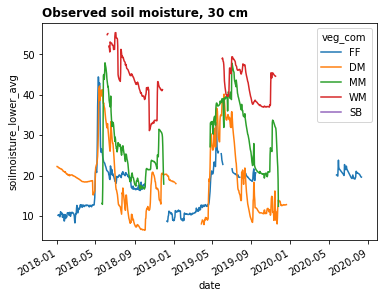

In [11]:
# soil moisture at data
dsSOI.where(dsSOI['date.year']>2017).soilmoisture_lower_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 30 cm', loc='left', fontsize='large', fontweight='bold');

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


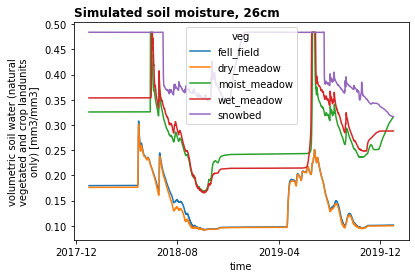

In [12]:
## Same for model
dsCLM.where(dsCLM['year']>2017).H2OSOI.isel(levsoi=4).plot.line(hue='veg');
plt.title('Simulated soil moisture, 26cm', loc='left', fontsize='large', fontweight='bold');

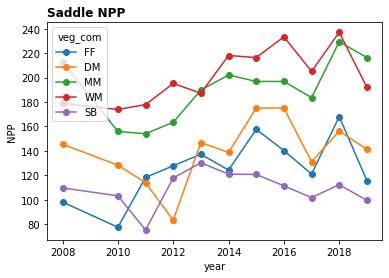

In [13]:
# NPP
dsNPP.where(dsNPP['year']>2005).NPP.plot(hue='veg_com',marker='o');
plt.title('Saddle NPP', loc='left', fontsize='large', fontweight='bold');

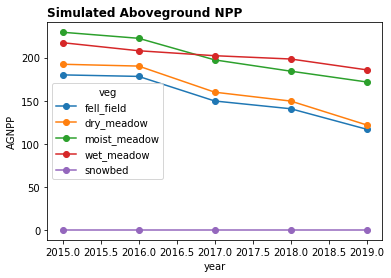

In [16]:
annPPT = dsCLM['ppt'].groupby(dsCLM['year']).mean()
annPPT = annPPT * 3600 * 24 * 365 / 10  #convert mm/s to cm/y
annNPP = dsCLM['AGNPP'].groupby(dsCLM['year']).mean()
annNPP = annNPP * 3600 * 24 * 365   #convert gC/m2/s to annual
annNPP.isel(veg=range(len(veg))).plot.line(x='year',marker='o');
plt.title('Simulated Aboveground NPP', loc='left', fontsize='large', fontweight='bold');

--------------------------
## Sample of time series results in each  community

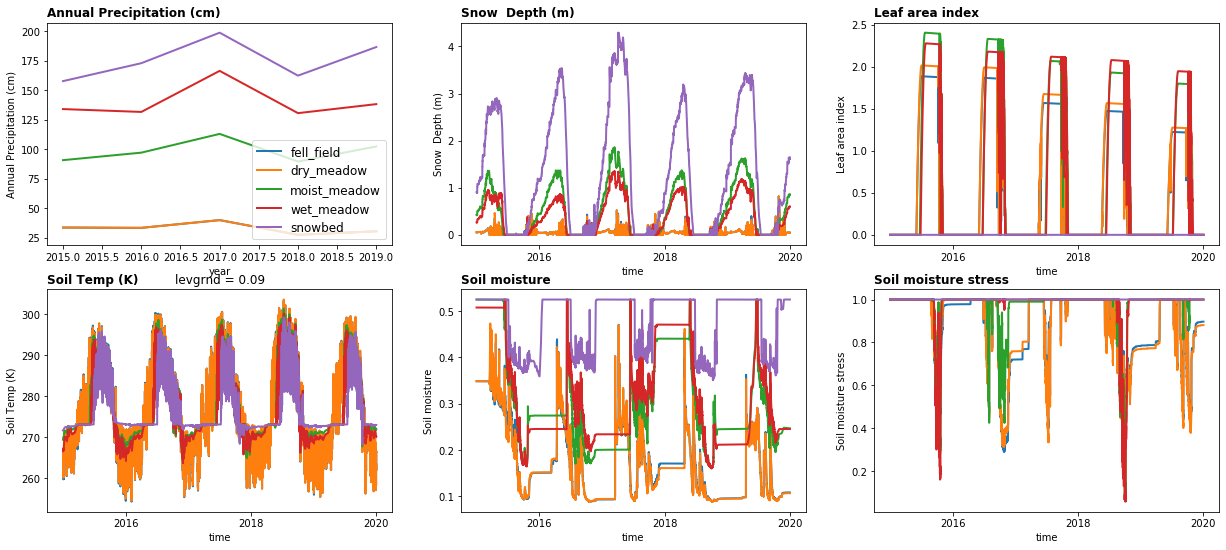

In [15]:
plotVars = ['ppt','SNOW_DEPTH','ELAI','TSOI','H2OSOI','BTRAN2']
plotLabs = ['Annual Precipitation (cm)', "Snow  Depth (m)",
           'Leaf area index', 'Soil Temp (K)',
           'Soil moisture', 'Soil moisture stress']
dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values
nlev=2 #select soil layer , 2 = 9cm
plt.figure(figsize=[21,9])

for i in range(len(plotLabs)):
    if i == 0:
        plt.subplot(231)
        annPPT.plot.line(x='year', hue="veg",add_legend=False,LineWidth = 2)
        plt.legend(longSite,frameon=True,fontsize='large',loc='lower right')
    else:
        plt.subplot(2,3,(i+1))
        if i == 3:
            dsCLM[plotVars[i]].isel(levgrnd=nlev).plot.line(
                x='time', hue="veg",add_legend=False,LineWidth = 2)
        elif i == 4:
            dsCLM[plotVars[i]].isel(levsoi=nlev).plot.line(
                x='time', hue="veg",add_legend=False,LineWidth = 2)
        else:
            dsCLM[plotVars[i]].plot.line(
                x='time', hue="veg",add_legend=False,LineWidth = 2)

    plt.title(plotLabs[i],loc='left', fontsize='large', fontweight='bold')
    plt.ylabel(plotLabs[i]);

### Plots of depth resolved temperature and moisture

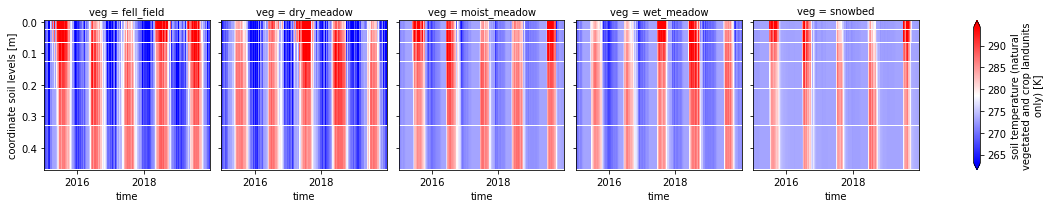

In [16]:
simple = dsCLM.TSOI.isel(levgrnd=(slice(0,6))).plot(x="time",yincrease=False, robust=True, col='veg', col_wrap=5,cmap='bwr'); 

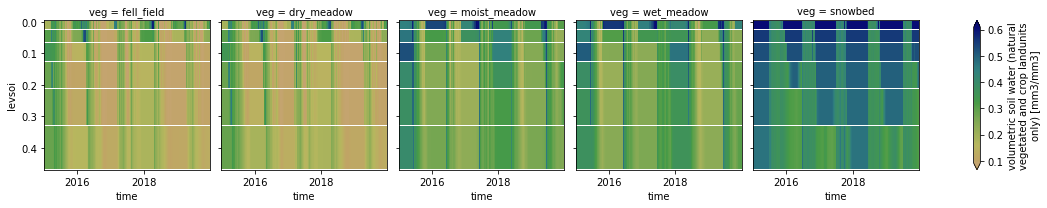

In [17]:
# Now truncate the cmap
cmap_mod = utils.truncate_colormap(cmapIn='gist_earth_r',minval=.2, maxval=0.95)  # calls function to truncate colormap

# Assign depths to soil levels & plot 
temp = dsCLM['H2OSOI'].copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
simple = temp.isel(levsoi=(slice(0,6))).plot(
    x="time",yincrease=False, robust=True, col='veg', col_wrap=5,cmap=cmap_mod);

### Plot soil moisture by year for 3 communities

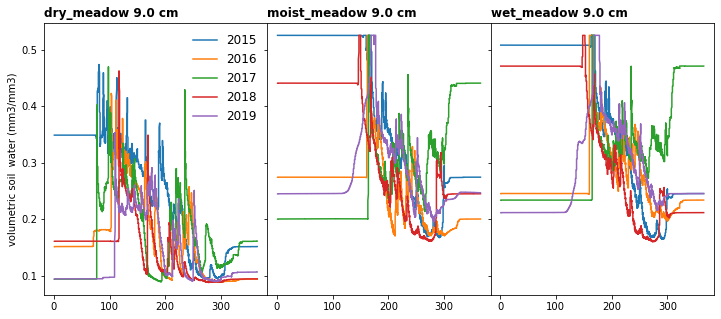

In [18]:
nyear = len(years) 
nlev = 2
fig, axs = plt.subplots(1, 3, 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,5))    
for v in range(3):    
    for i in range(nyear):
        x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[i])
        y = dsCLM.H2OSOI.isel(levsoi=nlev,veg=(v+1)).where(dsCLM['year']==years[i])
        axs[v].plot(x, y, '-')
    depth = str(np.round(dsCLM["levgrnd"].isel(levgrnd=nlev).values * 100,0)) 
    axs[v].set_title(fullVeg[(v+1)]+" "+depth+' cm', 
                     loc='left', fontsize='large', fontweight='bold')
    if v == 0:
        axs[v].legend(years,frameon=False,fontsize='large',loc='upper right')
        axs[v].set_ylabel('volumetric soil  water (mm3/mm3)');


### Plot simulated runoff
focus on DM, MM, WM

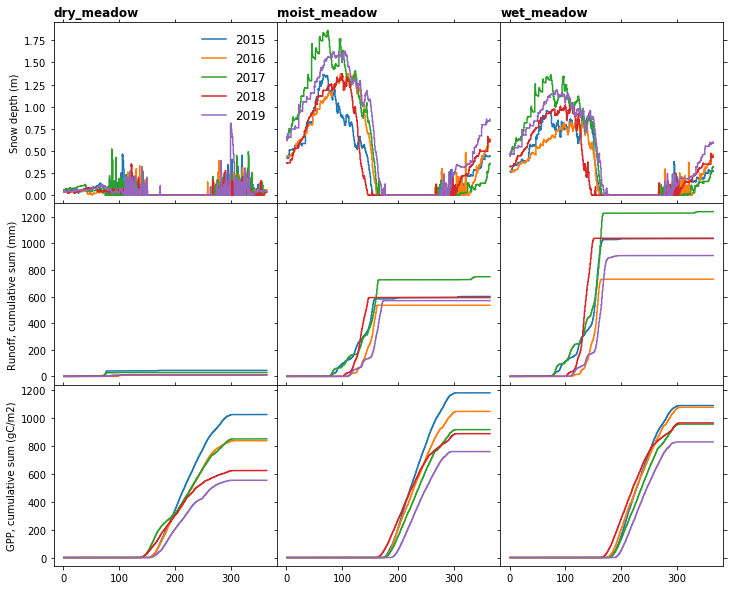

In [19]:
nyear = len(years) 
nveg =1
fig, axs = plt.subplots(3, 3, 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))    

for p in range(3):  #loop over variables (snow, runoff, GPP), rows
    for v in range(3): # loop over veg communities (DM, MM, WM), columns
        for i in range(nyear): # loop over years
            x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[i])
            if p == 0:
                y = dsCLM.SNOW_DEPTH.isel(veg=(v+1)).where(dsCLM['year']==years[i])
            elif p == 1: 
                y = dsCLM.QRUNOFF.isel(veg=(v+1)).where(dsCLM['year']==years[i])
                y = y.cumsum(dim='time')*30*60  #convert mm/s flux to mm water
            else:
                y = dsCLM.GPP.isel(veg=(v+1)).where(dsCLM['year']==years[i])
                y = y.cumsum(dim='time')*30*60  #convert gC/m2/s 

            axs[p,v].plot(x, y, '-') 
            axs[p,v].yaxis.set_ticks_position('both')                                                                                                                                                                                                                                  
            axs[p,v].xaxis.set_ticks_position('both')     

        axs[0,v].set_title(fullVeg[(v+1)], loc='left', fontsize='large', fontweight='bold')
        if v == 0:
            axs[0,v].legend(years,frameon=False,fontsize='large',loc='upper right')
            axs[0,v].set_ylabel('Snow depth (m)')        
            axs[1,v].set_ylabel('Runoff, cumulative sum (mm)')        
            axs[2,v].set_ylabel('GPP, cumulative sum (gC/m2)');


### Runoff as function of snow depth in each community

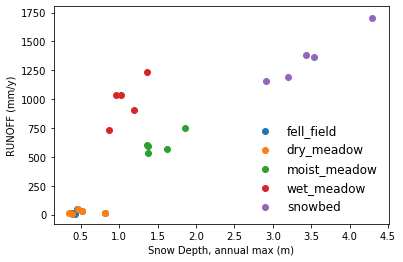

In [20]:
for i in range(5):
    x = dsCLM.SNOW_DEPTH.isel(veg=i).groupby(dsCLM['year']).max()
    y = dsCLM.QRUNOFF.isel(veg=i).groupby(dsCLM['year']).sum() * 30 * 60
    plt.scatter(x, y);

plt.legend(fullVeg,frameon=False,fontsize='large',loc='lower right')
plt.xlabel('Snow Depth, annual max (m)');
plt.ylabel('RUNOFF (mm/y)');

### Plot soil moisture and temperature for single year

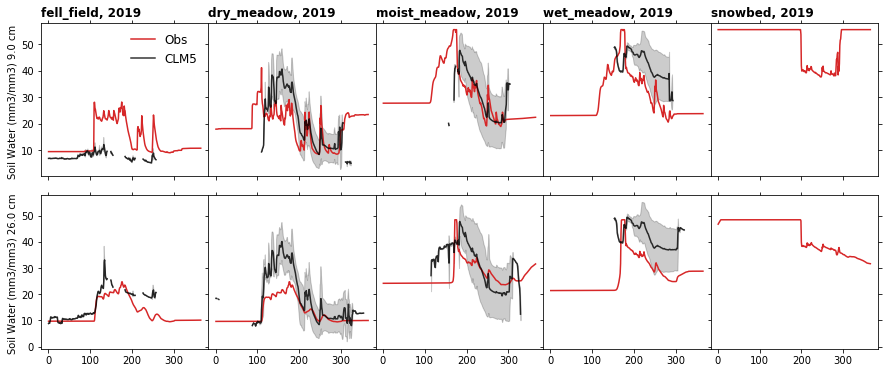

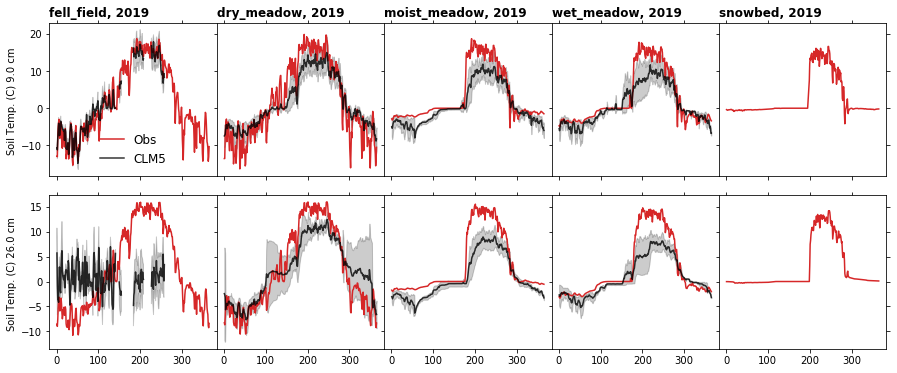

In [21]:
nyear = len(years) 
clmVARS = ['H2OSOI','TSOI']
obsVARSu = ['soilmoisture_upper_avg','soiltemp_upper_avg']
obsVARSl = ['soilmoisture_lower_avg','soiltemp_lower_avg']
plotYear =  2019

for v in range(len(clmVARS)):
    fig, axs = plt.subplots(2, len(Veg), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0.12},
                        figsize=(15,6))    
    for i in range(len(Veg)):
        for j in range(2):
            if i == 0: 
                nlev = 2 #10 cm for fell field
            else: 
                nlev = 1 # 5 cm for sensor network
            if j == 1: nlev = 4

            # Srelect data to plot    
            x = dsCLM['time.dayofyear'].where(dsCLM['year']==plotYear)
            x2 = dsSOI['date.dayofyear'].where(dsSOI['date.year']==plotYear)

            if v == 0:
                y = dsCLM[clmVARS[v]].isel(levsoi=nlev,veg=i).where(dsCLM['year']==plotYear).groupby(x).mean() * 100
            else:
                y = dsCLM[clmVARS[v]].isel(levgrnd=nlev,veg=i).where(dsCLM['year']==plotYear).groupby(x).mean() -273.15
            
            if j == 0: 
                y2 = dsSOI[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if j == 1: 
                y2 = dsSOI[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            x = x.groupby(x).mean()
            
            axs[j,i].plot(x, y, '-',color='tab:red')
            axs[j,i].plot(x2, y2, '-', color='k', alpha=0.8)
            axs[j,i].fill_between(x2, y2-ySTD, y2+ySTD, alpha=0.2,color='k')
            axs[j,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
            axs[j,i].xaxis.set_ticks_position('both')     


            # control titles & axis labels
            # label colums of data with variables name
            depth = str(np.round(dsCLM["levgrnd"].isel(levgrnd=nlev).values * 100,0))
            if j == 0:
                axs[j,i].set_title(fullVeg[i]+", "+str(plotYear), 
                                   loc='left', fontsize='large', fontweight='bold')
                if i == 0 :
                    axs[j,i].legend(('Obs','CLM5'), frameon=False,fontsize='large')
            #if j == 1:
                #axs[j,i].set_title(depth + " cm ", loc='left', fontsize='large', fontweight='bold')
            if i == 0:
                if v == 0:
                    axs[j,i].set_ylabel('Soil Water (mm3/mm3) '+depth+ " cm ");
                else:
                    axs[j,i].set_ylabel('Soil Temp. (C) '+depth+ " cm ");